# Springboard Time Series - 'Cowboy Cigarettes' Case Study - Tier 3

## Brief

You're working in the US federal government as a data scientist in the Health and Environment department. You've been tasked with determining whether sales for the oldest and most powerful producers of cigarettes in the country are increasing or declining.

**Cowboy Cigarettes (TM, *est.* 1890)** is the US's longest-running cigarette manufacturer. Like many cigarette companies, however, they haven't always been that public about their sales and marketing data. The available post-war historical data runs for only 11 years after they resumed production in 1949; stopping in 1960 before resuming again in 1970. Your job is to use the 1949-1960 data to predict whether the manufacturer's cigarette sales actually increased, decreased, or stayed the same. You need to make a probable reconstruction of the sales record of the manufacturer - predicting the future, from the perspective of the past - to contribute to a full report on US public health in relation to major cigarette companies.

The results of your analysis will be used as part of a major report relating public health and local economics, and will be combined with other studies executed by your colleagues to provide important government advice.  

-------------------------------
As ever, this notebook is **tiered**, meaning you can elect that tier that is right for your confidence and skill level. There are 3 tiers, with tier 1 being the easiest and tier 3 being the hardest.  

**1. Sourcing and loading**
- Load relevant libraries
- Load the data
- Explore the data


**2. Cleaning, transforming and visualizing**
- Dropping unwanted columns
- Nomenclature
- Type conversions
- Making a predictor variable `y`
- Getting summary statistics for `y`
- Plotting `y`
  
  
**3. Modelling**
- Decomposition
    - Trend
    - Seasonality
    - Noise
- Testing for stationarity with KPSS
- Making the data stationary
- The ARIMA Model
    - Make a function to find the MSE of a single ARIMA model
    - Make a function to evaluate the different ARIMA models with different p, d, and q values
- Visualize the results
- Application: Forecasting

**4. Evaluating and concluding**
- What is our conclusion?
- Next steps
    

## 0. Preliminaries

Time series data is just any data displaying how a single variable changes over time. It comes as a collection of metrics typically taken at regular intervals. Common examples of time series data include weekly sales data and daily stock prices. You can also easily acquire time series data from [Google Trends](https://trends.google.com/trends/?geo=US), which shows you how popular certain search terms are, measured in number of Google searches.

## 1. Sourcing and Loading

### 1a. Load relevant libraries

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import itertools

### 1b. Load the data
Call the variable `cigData`.

In [39]:
cigData = pd.read_csv('/content/CowboyCigsData.csv')
print(cigData)

     Unnamed: 0     Time  #CigSales
0             0  1949-01    1000112
1             1  1949-02    1000118
2             2  1949-03    1000132
3             3  1949-04    1000129
4             4  1949-05    1000121
..          ...      ...        ...
139         139  1960-08    1000606
140         140  1960-09    1000508
141         141  1960-10    1000461
142         142  1960-11    1000390
143         143  1960-12    1000432

[144 rows x 3 columns]


### 1c. Explore the data
We now need to check whether the data conduces to a time series style analysis.

In [40]:
cigData.head()

,Unnamed: 0,Time,#CigSales
0,0,1949-01,1000112
1,1,1949-02,1000118
2,2,1949-03,1000132
3,3,1949-04,1000129
4,4,1949-05,1000121


Over a million cigarettes sold in the month of January 1949. This certainly is a popular cigarette brand.

Check out the columns feature of the data. How many columns are there?

In [41]:
cigData.columns

Index(['Unnamed: 0', 'Time', '#CigSales'], dtype='object')

Let's check out the data types of our columns.

In [42]:
cigData.dtypes

,0
Unnamed: 0,int64
Time,object
#CigSales,int64


Check whether there are any null values.

In [43]:
cigData.isnull().sum()

,0
Unnamed: 0,0
Time,0
#CigSales,0


## 2. Cleaning, transforming and visualizing

### 2a. Dropping unwanted columns
We need to cut that `Unnamed: 0` column. Delete it here.

In [44]:
cigData = cigData.drop(columns=['Unnamed: 0'])
cigData.head()

,Time,#CigSales
0,1949-01,1000112
1,1949-02,1000118
2,1949-03,1000132
3,1949-04,1000129
4,1949-05,1000121


### 2b. Nomenclature

We can see that the `Time` column actually has the granularity of months. Change the name of that column to `Month`.

In [45]:
cigData.rename(columns={'Time': 'Month'}, inplace=True)

Call a head() to check this has worked.

In [46]:
cigData.head()

,Month,#CigSales
0,1949-01,1000112
1,1949-02,1000118
2,1949-03,1000132
3,1949-04,1000129
4,1949-05,1000121


### 2c. Type conversions

Now, do time series analysis on a Pandas dataframe is overkill, and is actually counter-productive. It's much more easy to carry out this type of analysis if we convert our data to a series first.

Notice that the `Month` field was an object. Let's type convert the `Month` column to a Python `datetime`, before making that the index.

In [47]:
cigData['Month'] = pd.to_datetime(cigData['Month'])

Perfect!

### 2d. Making a predictor variable `y`

The data is now indexed by date, as time series data ought to be.

Since we want to predict the number of cigarette sales at Cowboy cigarettes, and `y` is typically used to signify a predictor variable, let's create a new variable called `y` and assign the indexed #Passenger column.

In [48]:
y = cigData['#CigSales']

Check the type of our new variable.

In [49]:
type(y)

pandas.core.series.Series

### 2e. Getting summary statistics for `y`

Get the summary statistics of our data here.

In [50]:
y.describe()

,#CigSales
count,1.440000e+02
mean,1.000280e+06
std,1.199663e+02
min,1.000104e+06
25%,1.000180e+06
50%,1.000266e+06
75%,1.000360e+06
max,1.000622e+06


Try visualizing the data. A simple `matplotlib` plot should do the trick.  

### 2f. Plotting `y`

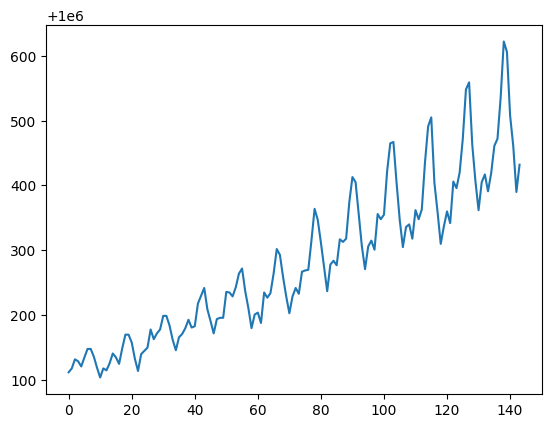

In [51]:
plt.plot(y)

## 3. Modelling
### 3a. Decomposition
What do you notice from the plot? Take at least `2` minutes to examine the plot, and write down everything you observe.  

All done?

We can see that, generally, there is a trend upwards in cigarette sales from at Cowboy Cigarettes. But there are also some striking - and perhaps unexpected - seasonal fluctuations. These seasonal fluctations come in a repeated pattern. Work out when these seasonal fluctuations are happening, and take 2 minutes to hypothesize on their cause here.

What does it mean to *decompose* time series data? It means breaking that data into 3 components:

1. **Trend**: The overall direction that the data is travelling in (like upwards or downwards)
2. **Seasonality**: Cyclical patterns in the data
3. **Noise**: The random variation in the data

We can treat these components differently, depending on the question and what's appropriate in the context. They can either be added together in an *additive* model, or multiplied together in a *multiplicative* model.

Make a coffee, take `5` minutes and read [this article](https://medium.com/@sigmundojr/seasonality-in-python-additive-or-multiplicative-model-d4b9cf1f48a7) and think about whether our data would conduce to an additive or multiplicative model here. Write your conclusion down just here:

-------------------------------

All done? Well, just on the basis of the plot above, it seems our Cowboy Cigarettes data is actually multiplicative.

That's because, as time progresses, the general trend seems to be increasing *at a rate that's also increasing*. We also see that the seasonal fluctuations (the peaks and troughs) get bigger and bigger as time progresses.

Now on the other hand, if the data were simply additive, we could expect the general trend to increase at a *steadily*, and a constant speed; and also for seasonal ups and downs not to increase or decrease in extent over time.

Happily, we can use the `decompose()` function to quantify the component parts described above in our data.

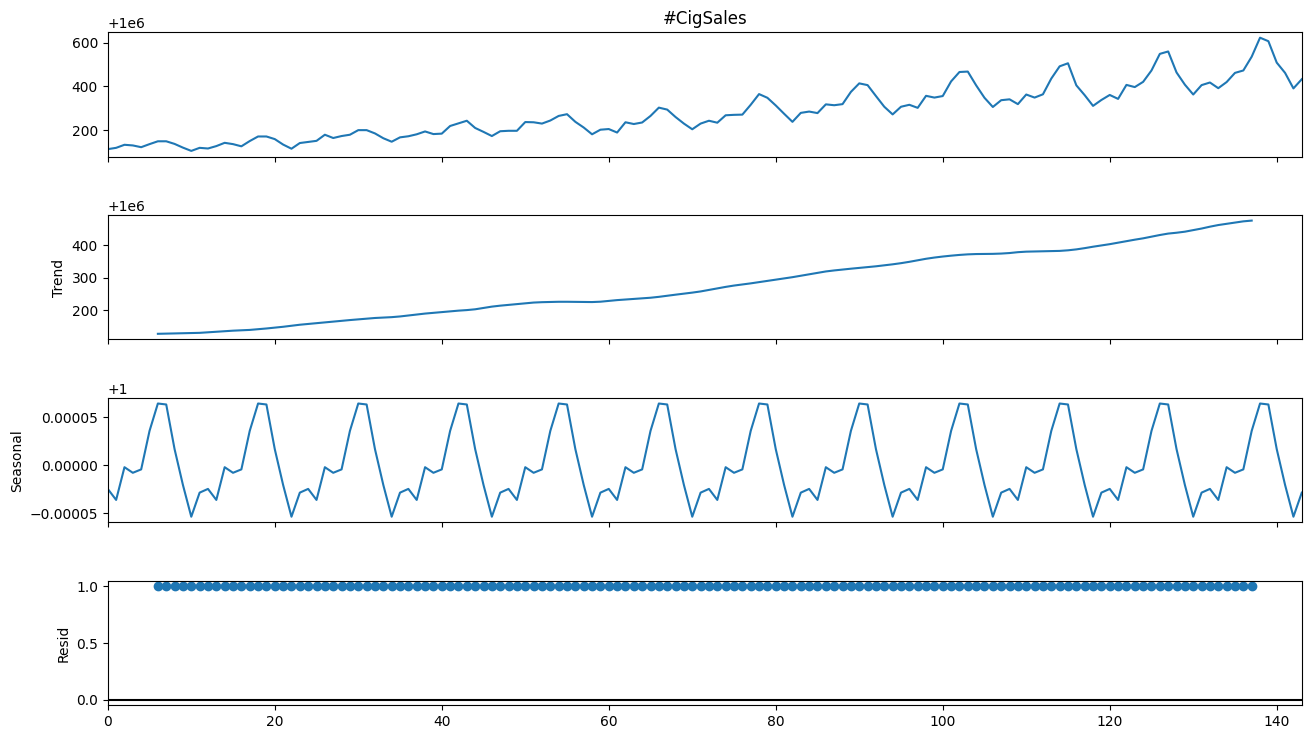

In [52]:
decomposition = sm.tsa.seasonal_decompose(y, model='multiplicative', period=12)

# Plot the original data, the trend, the seasonality, and the residuals
fig = decomposition.plot()
fig.set_size_inches(15, 8)

### 3b. Testing for stationarity with KPSS
As you know, when doing time series analysis we always have to check for stationarity. Imprecisely, a time series dataset is stationary just if its statistical features don't change over time. A little more precisely, a stationary time series dataset will have constant mean, variance, and covariance.

There are many ways to test for stationarity, but one of the most common is the KPSS test. The Null hypothesis of this test is that the time series data in question is stationary; hence, if the *p*-value is less than the significance level (typically 0.05, but we decide) then we reject the Null and infer that the data is not stationary.

In [53]:
from statsmodels.tsa.stattools import kpss
kpss(y, regression='c', nlags='auto')

/tmp/ipython-input-53-2923557093.py:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss(y, regression='c', nlags='auto')


(np.float64(1.651312235417082),
 np.float64(0.01),
 8,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

Since our p-value is less than 0.05, we should reject the Null hypothesis and deduce the non-stationarity of our data.

But our data need to be stationary! So we need to do some transforming.

### 3c. Making the data stationary
Let's recall what it looks like.

<Axes: >

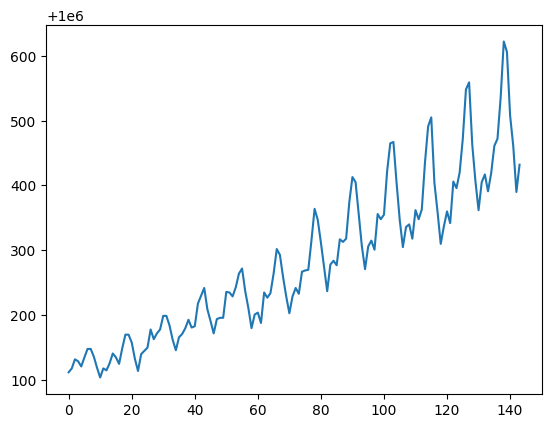

In [54]:
y.plot()

In our plot, we can see that both the mean and the variance *increase as time progresses*. At the moment, our data has neither a constant mean, nor a constant variance (the covariance, however, seems constant).

One ofte  used way of getting rid of changing variance is to take the natural log of all the values in our dataset. Let's do this now.

In [55]:
Vd = np.log(y)


When you plot this, you can see how the variance in our data now remains contant over time.

<Axes: >

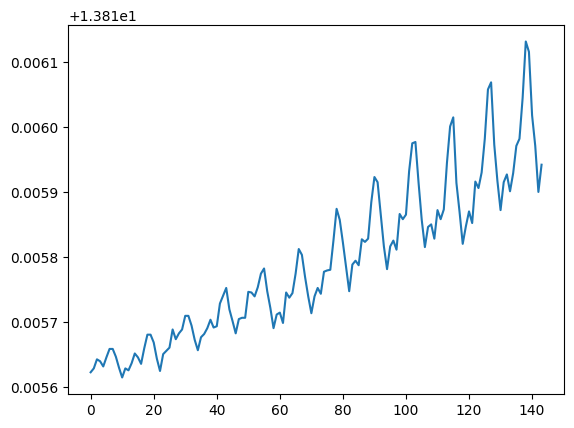

In [56]:
Vd.plot()

We now have a constant variance, but we also need a constant mean.

We can do this by *differencing* our data. We difference a time series dataset when we create a new time series comprising the difference between the values of our existing dataset.

Python is powerful, and we can use the `diff()` function to do this. You'll notice there's one less value than our existing dataset (since we're taking the difference between the existing values).

/tmp/ipython-input-57-265455869.py:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss(Vd, regression='c', nlags='auto')


(np.float64(1.6513318050466144),
 np.float64(0.01),
 8,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

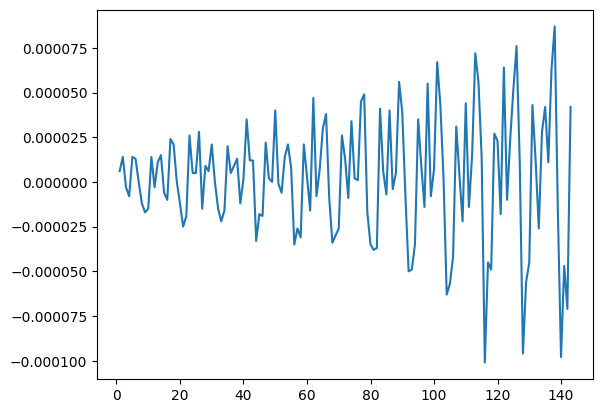

In [57]:
Vd.diff().plot()
Vd.dropna(inplace=True)
kpss(Vd, regression='c', nlags='auto')

Our p-value is now greater than 0.05, so we can accept the null hypothesis that our data is stationary.

### 3d. The ARIMA model

Recall that ARIMA models are based around the idea that it's possible to predict the next value in a time series by using information about the most recent data points. It also assumes there will be some randomness in our data that can't ever be predicted.

We can find some good parameters for our model using the `sklearn` and `statsmodels` libraries, and in particular `mean_squared_error` and `ARIMA`.

In [58]:
# Import mean_squared_error and ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA

#### 3di. Make a function to find the MSE of a single ARIMA model
Things get intricate here. Don't worry if you can't do this yourself and need to drop down a Tier.

In [59]:
def evaluate_arima_model(series, arima_order):
    """
    Fit ARIMA model and return Mean Squared Error (MSE)

    Parameters:
    series (pd.Series): Time series data
    arima_order (tuple): ARIMA order (p, d, q)

    Returns:
    float: Mean Squared Error
    """
    # Split into train and test sets
    train_size = int(len(series) * 0.8)
    train, test = series[:train_size], series[train_size:]

    # Fit ARIMA model
    model = ARIMA(train, order=arima_order)
    model_fit = model.fit()

    # Forecast
    predictions = model_fit.forecast(steps=len(test))

    # Calculate MSE
    mse = mean_squared_error(test, predictions)
    return mse

#### 3dii. Make a function to evaluate the different ARIMA models with different p, d, and q values

In [60]:
# Make a function to evaluate different ARIMA models with several different p, d, and q values.
def evaluate_models(series, p_values, d_values, q_values):
    best_score, best_cfg = float("inf"), None
    results = []

    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p, d, q)
                try:
                    mse = evaluate_arima_model(series, order)
                    results.append((order, mse))
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print(f"ARIMA{order} MSE={mse:.4f}")
                except Exception as e:
                    print(f"ARIMA{order} failed: {e}")
                    continue

    return {"best_order": best_cfg, "best_mse": best_score, "all_results": results}


In [61]:
# Now, we choose a couple of values to try for each parameter.
p_values = range(0, 3)
d_values = range(0, 2)
q_values = range(0, 3)


In [62]:
# Finally, we can find the optimum ARIMA model for our data.
# Nb. this can take a while...!

result = evaluate_models(y, p_values, d_values, q_values)


ARIMA(0, 0, 0) MSE=46249.6288
ARIMA(0, 0, 1) MSE=44249.4532


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(0, 0, 2) MSE=43647.6730
ARIMA(0, 1, 0) MSE=8673.9310
ARIMA(0, 1, 1) MSE=8939.9520
ARIMA(0, 1, 2) MSE=8950.9833
ARIMA(1, 0, 0) MSE=9175.7165
ARIMA(1, 0, 1) MSE=16627.9521
ARIMA(1, 0, 2) MSE=10726.5459
ARIMA(1, 1, 0) MSE=8971.0342
ARIMA(1, 1, 1) MSE=8963.4919
ARIMA(1, 1, 2) MSE=8063.8475
ARIMA(2, 0, 0) MSE=16427.3104
ARIMA(2, 0, 1) MSE=12336.6765


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(2, 0, 2) MSE=13207.8004
ARIMA(2, 1, 0) MSE=8928.4368
ARIMA(2, 1, 1) MSE=8003.6083
ARIMA(2, 1, 2) MSE=5906.3305


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


So the best p,d, q, parameters for our ARIMA model are 2, 1, 1 respectively. Now we know this, we can build the model.

In [63]:
best_order = (2, 1, 2)
model = ARIMA(y, order=best_order)
model_fit = model.fit()



/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


We can take a look at a summary of the model this library has built around our data.

In [64]:
# Print model summary
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:              #CigSales   No. Observations:                  144
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -692.547
Date:                Wed, 16 Jul 2025   AIC                           1395.094
Time:                        21:51:17   BIC                           1409.909
Sample:                             0   HQIC                          1401.114
                                - 144                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.7470      0.016    111.295      0.000       1.716       1.778
ar.L2         -0.9991      0.015    -68.430      0.000      -1.028      -0.970
ma.L1         -1.7496      0.216     -8.085      0.0

### 3e. Visualize the results

Visualize the original dataset plotted against our model.

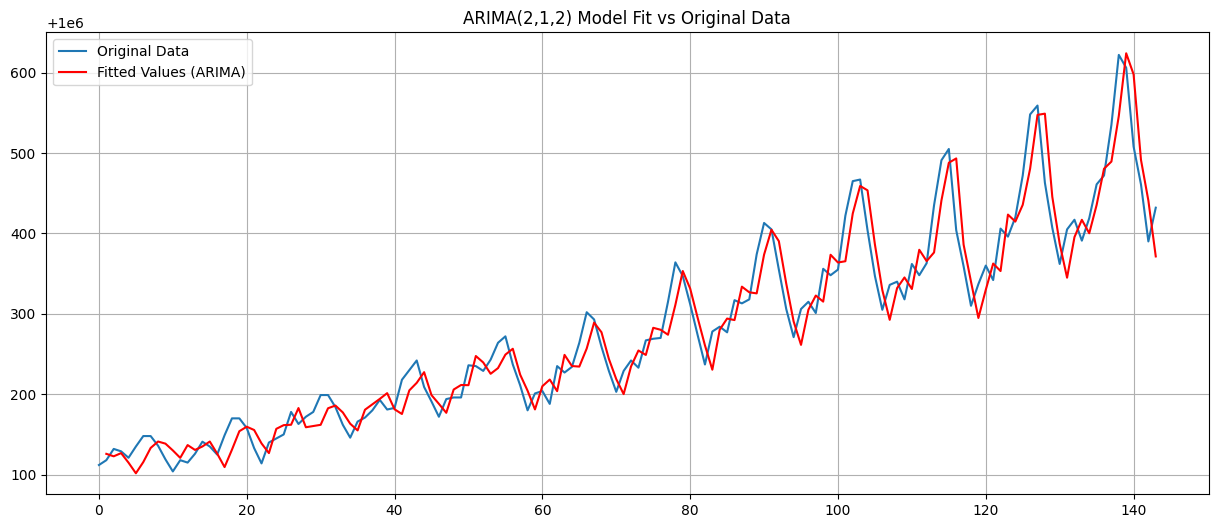

In [65]:
# Predict in-sample values
pred = model_fit.predict(start=1, end=len(y)-1, typ='levels')  # typ='levels' for undifferenced

# Match index
pred.index = y.index[1:]  # skip first index due to differencing

# Plot actual vs predicted
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6))
plt.plot(y, label='Original Data')
plt.plot(pred, label='Fitted Values (ARIMA)', color='red')
plt.title('ARIMA(2,1,2) Model Fit vs Original Data')
plt.legend()
plt.grid(True)
plt.show()


### 3f. Application: Forecasting

We've done well: our model fits pretty closely to our existing data. Let's now use it to forecast what's likely to occur in future.

/tmp/ipython-input-66-1444675705.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_index = pd.date_range(start=y.index[-1], periods=forecast_steps + 1, freq='M')[1:]


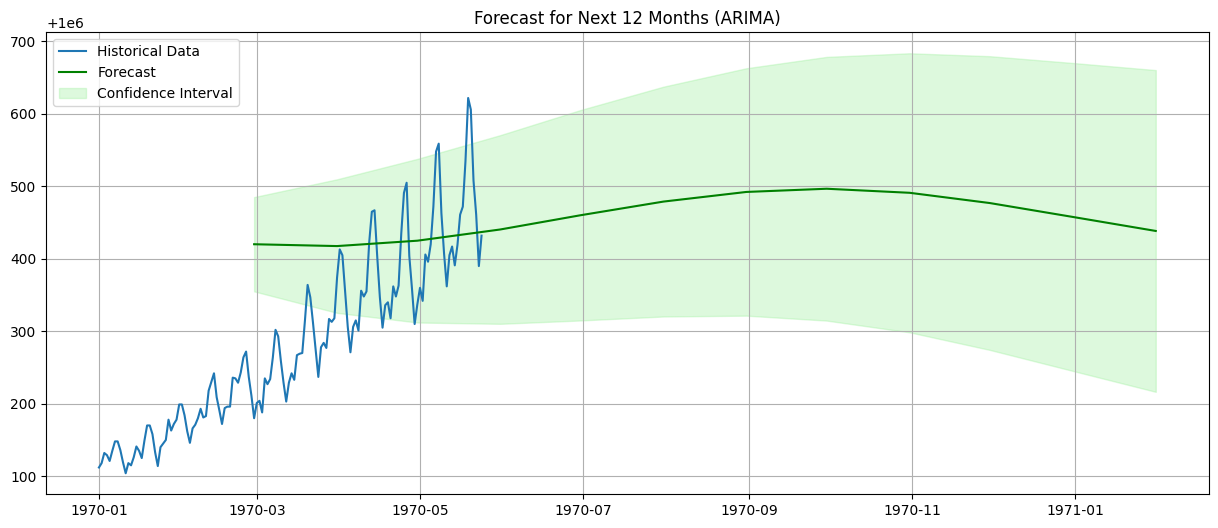

In [66]:
# Declare a variable called forecast_period with the amount of months to forecast, and
# create a range of future dates that is the length of the periods you've chosen to forecast
forecast_steps = 12
forecast_result = model_fit.get_forecast(steps=forecast_steps)
mean_forecast = forecast_result.predicted_mean
conf_int = forecast_result.conf_int()
future_index = pd.date_range(start=y.index[-1], periods=forecast_steps + 1, freq='M')[1:]

# Convert that range into a dataframe that includes your predictions
mean_forecast.index = future_index
conf_int.index = future_index

# Plot your future predictions
plt.figure(figsize=(15, 6))
plt.plot(y, label='Historical Data')
plt.plot(mean_forecast, label='Forecast', color='green')
plt.fill_between(conf_int.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1],
                 color='lightgreen', alpha=0.3, label='Confidence Interval')
plt.title('Forecast for Next 12 Months (ARIMA)')
plt.legend()
plt.grid(True)
plt.show()

## 4. Evaluating and Concluding

Our model captures the centre of a line that's increasing at a remarkable rate. Cowboy Cigarettes sell more cigarettes in the summer, perhaps due to the good weather, disposable income and time off that people enjoy, and the least in the winter, when people might be spending less and enjoying less free time outdoors.

Remarkably, our ARIMA model made predictions using just one variable. We can only speculate, however, on the causes of the behaviour predicted by our model. We should also take heed that spikes in data, due to sudden unusual circumstances like wars, are not handled well by ARIMA; and the outbreak of the Vietnam War in the 1960s would likely cause our model some distress.  

We could suggest to our employers that, if they are interested in discovering the causes of the cigarette sales trajectory, they execute a regression analysis in addition to the time series one.